# Retrieving bill data from the LegiScan API

In [1]:
import sys

# append the directory of election_crimes module to sys.path list
sys.path.append('../00_modules/')

%load_ext autoreload
%autoreload 2

In [2]:
import base64
import json
import os
from pathlib import Path

import numpy as np
import pandas as pd
import pdfplumber
import requests
from document import DataDictionary, StaticTables
from IPython.display import HTML, Image
from legcop import LegiScan

In [3]:
dictionary = DataDictionary('../01_inputs/documentation/bill_data_dict.json')
static_tables = StaticTables()
legis = LegiScan()

## Retrieve a bill

You could do this the old-fashioned way:

In [4]:
r = requests.get(
    'https://api.legiscan.com/',
    params={
        'key': os.getenv('LEGISCAN_API_KEY'),
        'op': 'getBill',
        'state': 'US',
        'bill': 'HB8404',
    },
)

In [6]:
r.json()['bill']['title']

'Respect for Marriage Act'

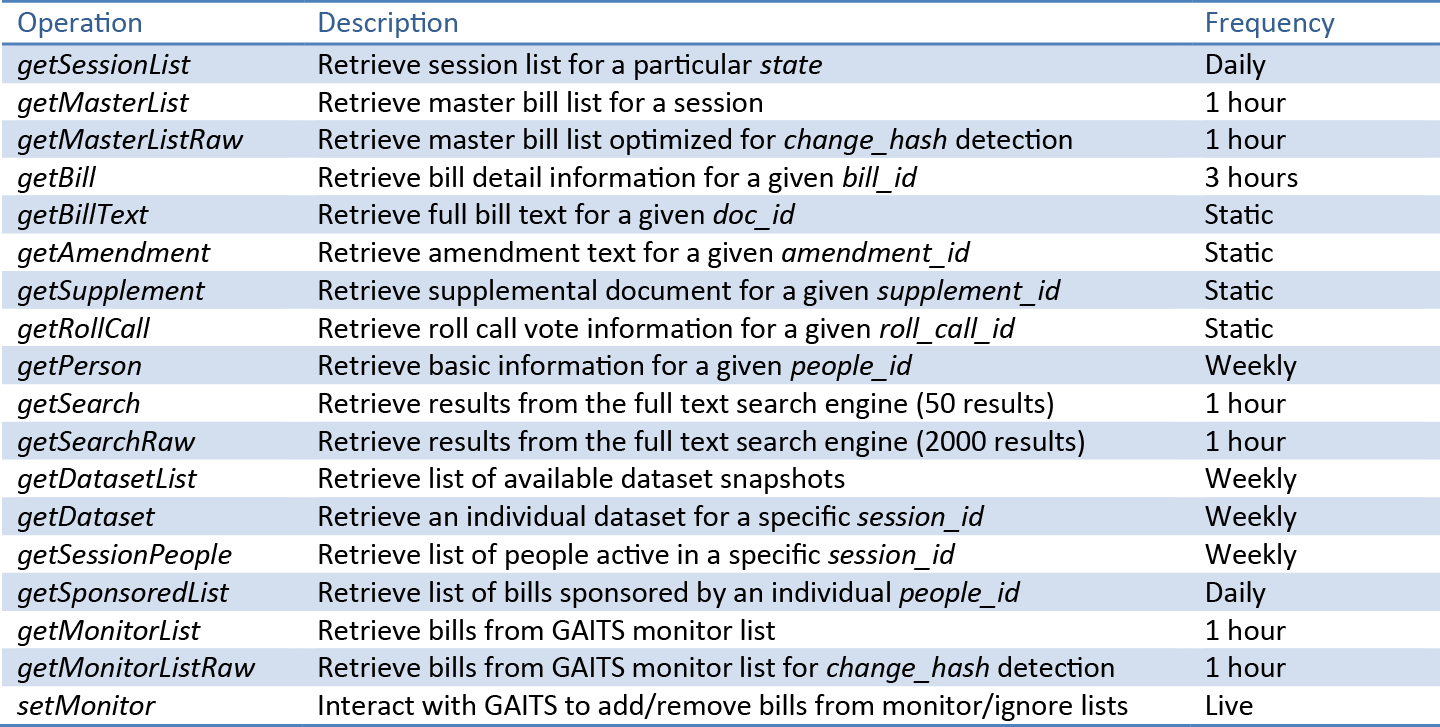

In [8]:
Image(filename='../01_inputs/documentation/operations.png')

Or you could use a preexisting Python wrapper:

In [4]:
# legis = LegiScan(apikey=os.getenv('LEGISCAN_API_KEY'))
# hb8404 = legis.get_bill(state='US', bill_number='HB8404')

## Save bill object

In [9]:
def save_requested_bill(data: dict):
    """Save result returned by API to a JSON file.

    Parameters
    ----------
    data : dict
        Raw data returned by the LegiScan API

    use_bill_id : bool, default=True

    Returns
    -------
    None

    """
    try:
        Path('../01_inputs/bills').mkdir(exist_ok=True)
        filename = f'../01_inputs/bills/{data["bill_id"]}.json'
        with open(filename, 'w') as fp:
            json.dump(data, fp)
    except KeyError:
        print(f'This data does not have a `bill_id`. Keys found: {", ".join(keys)}')
    return f'Bill saved to {filename}'

In [ ]:
save_requested_bill(hb8404)

In [5]:
with open('../01_inputs/bills/hb8404["bill_id"].json') as fp:
    bill = json.load(fp)

In [6]:
bill

## Bill data

### `session`

In [7]:
dictionary.lookup(field='sponsors')

**Data type** of `sponsors`: <span style="color:green">list</span>

**Description**: Array of sponsors

In [8]:
dictionary.lookup('session', values=True)

,value,data_type,description
0,session_id,int,Internal session id
1,state_id,int,"Not documented as a ""session"" value in the API manual, but in general, this refers to ""Internal state id"""
2,year_start,int,Starting year of the session
3,year_end,int,Ending year of the session
4,prefile,int,"Flag for session being in prefile (0, 1)"
5,sine_die,int,"Flag for session being adjourned sine die (0, 1)"
6,prior,int,"Flag for session being archived out of production updates (0, 1)"
7,special,int,"Flag for being a special session (0, 1)"
8,session_tag,str,Not documented in the API manual
9,session_title,str,Normalized session title with year(s) and Regular/Special Session


In [9]:
dictionary.lookup('session')

**Data type** of `session`: <span style="color:green">dict</span>

**Description**: API manual describes it as "Array" of session information, but it returns a dict/json object

### `progress`

In [10]:
dictionary.lookup('progress', values=True)

,value,data_type,description,lookup
0,date,date,Date of event,
1,event,int,Internal event type id matching the history action.,static_tables.load('progress')


In [11]:
progress_table = StaticTables().load('progress')

In [12]:
progress_table[progress_table['progress_event'].isin([1, 9])]

,progress_event,progress_desc
0,1,Introduced
8,9,Refer


### `committee`

In [14]:
dictionary.lookup('committee', values=True)

,value,data_type,description,lookup
0,committee_id,int,Internal committee id,legis.get_person()
1,chamber,str,Chamber of committee,
2,chamber_id,int,Internal body id.,body.csv
3,name,str,Name of committee,


In [15]:
body_table = static_tables.load('body')

In [16]:
body_table

,body_id,state_id,role_id,body_name,body_abbr,body_short,body_role_abbr,body_role_name
0,1,48,1,House of Delegates,H,House,Del,Delegate
1,2,48,2,Senate,S,Senate,Sen,Senator
2,3,38,1,House of Representatives,H,House,Rep,Representative
3,4,38,2,Senate,S,Senate,Sen,Senator
4,5,35,1,House of Representatives,H,House,Rep,Representative
...,...,...,...,...,...,...,...,...
119,123,52,3,Joint Conference,J,Joint,Jnt,Joint
120,124,6,3,Joint Conference,J,Joint,Jnt,Joint
121,125,15,3,Joint Conference,J,Joint,Jnt,Joint
122,126,20,3,Joint Conference,J,Joint,Jnt,Joint


In [17]:
body_table[body_table['body_id'] == 114]

,body_id,state_id,role_id,body_name,body_abbr,body_short,body_role_abbr,body_role_name
110,114,52,1,House of Representatives,H,House,Rep,Representative


### `referrals`

In [18]:
dictionary.lookup('referrals', values=True)

,value,data_type,description,lookup
0,date,date,Date of referral,
1,committee_id,int,Internal committee id,legis.get_person()
2,chamber,str,Chamber of committee,
3,chamber_id,int,Internal body id,static_tables.load('body')
4,name,str,"Name of committee; documented as ""committee_name"" in API manual",


### `history`

In [19]:
dictionary.lookup('history', values=True)

,value,data_type,description,lookup
0,date,date,Date of event,
1,action,str,Action step text,
2,chamber,str,Chamber taking action,
3,chamber_id,int,Internal body id,static_tables.load('body')
4,importance,bool,"Flag for ""major"" steps, i.e., matches a progress condition (0, 1)",


### `sponsors` 🔍

In [20]:
dictionary.lookup('sponsors', values=True)

,value,data_type,description,lookup
0,people_id,int,Internal people id,legis.get_person()
1,person_hash,str,Hash of the personal details to aid change detection,
2,party_id,int,Internal party id,static_tables.load('party')
3,state_id,int,"Not documented under ""sponsor"" in API manual, but elsewhere, state_id refers to an internal state id",
4,party,str,Party text,
5,role_id,int,Internal role id,static_tables.load('role')
6,role,str,Role text,
7,name,str,Full name,
8,first_name,str,First name,
9,middle_name,str,Middle name,


### `sasts` 🔍

In [21]:
dictionary.lookup('sasts')

**Data type** of `sasts`: <span style="color:green">list</span>

**Description**: Array of same as/similar to relations

### `subjects`

In [22]:
dictionary.lookup('subjects')

**Data type** of `subjects`: <span style="color:green">list</span>

**Description**: Array of subjects

### `texts` 🔍

In [23]:
dictionary.lookup('texts')

**Data type** of `texts`: <span style="color:green">list</span>

**Description**: Array of text drafts

In [24]:
def validate_text_obj(bill_obj, text_index, bill_identifier):
    if bill_identifier in ['bill_number', 'bill_id']:
        try:
            parent_dir = bill_obj[bill_identifier]
            text = bill_obj['texts'][text_index]
            text_type = text['type']
            parent_path = f'../04_outputs/pdfs/{parent_dir}/{text_type}'
            output_path = f'{parent_path}/{text["doc_id"]}.pdf'
            Path(parent_path).mkdir(parents=True, exist_ok=True)
            return text['doc_id'], output_path

        except IndexError as e:
            raise Exception(
                f'There are only {len(bill_obj["texts"])}' ' texts for this bill.'
            ) from e

        except KeyError as e:
            if e in ['bill_number', 'bill_id']:
                raise Exception(
                    f'{bill_identifier} is a valid identifier,'
                    ' but it was not found in \'bill_obj\'.'
                ) from e
            else:
                raise Exception(f'{e} was not found.')

    else:
        raise Exception(
            f'"{bill_identifier}" is not a valid identifier.'
            ' (\'bill_id\' or \'bill_number\')'
        )

In [25]:
def download_pdf(doc_id):
    """Summarize the function in one line.

    Several sentences providing an extended description. Refer to
    variables using back-ticks, e.g. `var`.

    Parameters
    ----------
    bill_obj : dict
        Dict returned by the Python wrapper used here for the LegiScan API,
        or by deserializing bill json from a file.
    text_index : int
        The position in the bill['texts'] array that corresponds to the
        document you wish to retrieve
    *args : iterable
        Other arguments.
    bill_identifier : {'bill_id', 'bill_number'}
        The identifier you want to use for constructing paths under which
        PDFs are saved, e.g. `1634314` if `bill_id` or `HJR100` if
        `bill_number`.

    Returns
    -------
    None

    Notes
    -----
    `bill_number`, while more readable than `bill_id`, is not unique across
    sessions or jurisdictions.
    """

    try:
        text_obj = legis.get_bill_text(doc_id, use_base64=True)
    except Exception as e:
        print(str(e))
    bill_id = text_obj['bill_id']
    with open(f'{output_path}', 'wb') as fp:
        fp.write(base64.b64decode(text_obj['doc']))
        print(f'File written to {output_path}')

In [505]:
download_pdf(bill, 0, 'bill_number')

File written to ../04_outputs/pdfs/HB3841/Introduced/2418284.pdf


In [513]:
with pdfplumber.open('../04_outputs/pdfs/HB3841/Introduced/2418284.pdf') as pdf:
    # for page in pdf.pages:
    first_page = pdf.pages[0]
    print(first_page.extract_text())

I 
117TH CONGRESS  H. R. 3841 
1ST SESSION 
To amend the Public Health Service Act with respect to the collection and 
availability of health data with respect to Indian Tribes, and for other 
purposes. 
IN  THE  HOUSE  OF  REPRESENTATIVES 
JUNE 11, 2021 
Mr. MULLIN (for himself and Mr. O’HALLERAN) introduced the following bill; 
which was referred to the Committee on Energy and Commerce 
A  BILL 
To  amend  the  Public  Health  Service  Act  with  respect  to 
the collection and availability of health data with respect 
to Indian Tribes, and for other purposes. 
1 Be it enacted by the Senate and House of Representa-
2 tives of the United States of America in Congress assembled, 
3
SECTION 1. SHORT TITLE. 
4 This Act may be cited as the ‘‘Tribal Health Data 
5 Improvement Act of 2021’’. 
S
BILL
with 
D 
O
R
P
X2
W7
V
KJL
S
D
pbinns on VerDate Sep 11 2014  23:13 Jun 18, 2021 Jkt 019200 PO 00000 Frm 00001 Fmt 6652 Sfmt 6201 E:\BILLS\H3841.IH H3841


### `votes`

In [26]:
dictionary.lookup('votes')

**Data type** of `votes`: <span style="color:green">list</span>

**Description**: Array of related roll calls

### `amendments`

In [27]:
dictionary.lookup('amendments')

**Data type** of `amendments`: <span style="color:green">list</span>

**Description**: {'data_type': 'str', 'description': 'Amendment Description'}

### `supplements`

In [28]:
dictionary.lookup('supplements')

**Data type** of `supplements`: <span style="color:green">list</span>

**Description**: {'data_type': 'str', 'description': 'Supplement description'}

### `calendar`

In [29]:
dictionary.lookup('calendar')

**Data type** of `calendar`: <span style="color:green">list</span>

**Description**: {'data_type': 'str', 'description': 'Event description'}